In [89]:
#Here, we will demonstrate how the leadfinding algorithm works
#First, import some modules

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, cv2, os
from scipy import stats
from Data.nsidc_functions import q_xml_decode, im_xml_decode
from matplotlib.gridspec import GridSpec
from datetime import datetime
from numpy import ma
import statsmodels.api as sm
from functools import reduce
from scipy.signal import peak_widths, argrelextrema

In [21]:
#First, we move to the demo directory with the demo data
head = '/home/jeffrey/cryo-toolbox/leadfind_demo/Data/'
os.chdir(head)

In [22]:
#Now we parse the jpg, xml files and load their details
#Each jpg has a corresponding xml file with lon/lat/time details
#Each geoidcorr_*.txt has a corresponding xml file with lon/lat/elevation details
#this is how we will link the jpg's to the elevation data
lspics = sorted(glob.glob("*.jpg"))
ls2 = sorted(glob.glob("*tif.xml"))
im_data = im_xml_decode(ls2, 2010.1030) #this is data from 2010/10/30, but this is not important here 
ls = sorted(glob.glob("*qi.xml"))
qi_data = q_xml_decode(ls)

minlons, minlats, maxlons, maxlats, starts, ends = qi_data
lat_start, lon_start, lat_stop, lon_stop, starts2, ends2, start_start, lonsall2, latsall2  = im_data

4 number of image files
2 number of qfit files


In [193]:
#Pick which image you want to look at (remember, there are 4)
# so acceptable inputs here are 0, 1, 2, 3
picindex = 0

In [194]:
#From the jpg xml data, find the corresponding lon/lat limits for filtering the elevations
lon_inspect_start, lon_inspect_end = lon_start[picindex], lon_stop[picindex]
lat_inspect_start, lat_inspect_end = lat_start[picindex], lat_stop[picindex]

In [195]:
#Using these limits, find which geoid_corr*.txt file to open
ind_guess1 = ((lon_inspect_start>minlons)+(lon_inspect_end>minlons))*\
((lon_inspect_end<maxlons)+(lon_inspect_start<maxlons))
ind_guess2 = ((lat_inspect_start>minlats)+(lat_inspect_end>minlats))*\
((lat_inspect_end<maxlats)+(lat_inspect_start<maxlats))
index = min(np.nonzero(ind_guess1*ind_guess2)[0])
print("File found... xml file #{}".format(index))

File found... xml file #0


In [196]:
print("Opening file...")
with open('geoidcorr_new_'+str(index).zfill(2)+'.txt', 'r') as f:
    lons, lats, elevs = np.loadtxt(f, unpack=True,usecols=(0,1,2), dtype='float64')

Opening file...


In [197]:
#Using the lon/lat filter from the image, reduce the lons/lats/elevs based on what we actually need
search_ind = (lons<(lon_inspect_end))*(lons>(lon_inspect_start))*(lats<(lat_inspect_end))*(lats>(lat_inspect_start))
qi_lons = lons[search_ind]
qi_lats = lats[search_ind]
qi_elevs = elevs[search_ind]

Text(0.5, 1.0, 'Fig 1. First look at the image (in greyscale)')

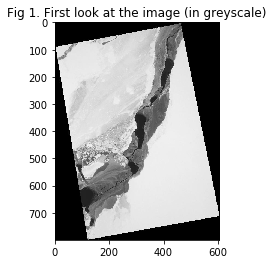

In [198]:
#now we stack the lon/lat data from the jpg's xml files, for orienting the image
latlons = np.dstack([lonsall2[picindex], latsall2[picindex]])[0]
#We open the image
im_bw = cv2.imread(lspics[picindex], cv2.IMREAD_GRAYSCALE)
plt.imshow(im_bw, cmap='Greys_r')
plt.title("Fig 1. First look at the image (in greyscale)")

In [199]:
#If the image is too dark, brighten the image by scalining the image intensities
if im_bw.max()<200:
	cutoff = np.percentile(im_bw, 99.9)
	im_bw[im_bw>cutoff] = cutoff
	im_bw = (im_bw/cutoff*255).astype('uint8')

	print("Dark image; brightening")
else:
    cutoff = 250
    print("Image is bright enough already")

Image is bright enough already


Text(0.5, 0.98, 'Fig 2. Applying mask to remove black background')

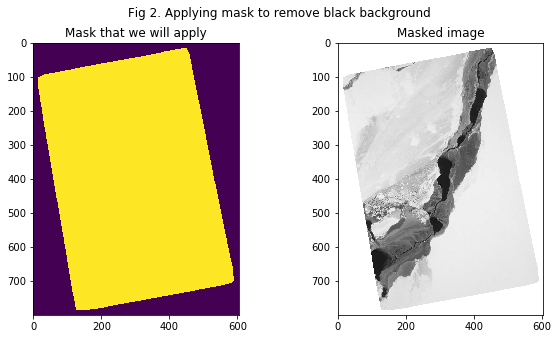

In [200]:
# Fig 1. actually has black pixels (not 'empty' pixels) around the image 
# We need to get rid of these first. To do this, we apply a binary filter and find the largest contour
_, im_thresh = cv2.threshold(im_bw, 1,255, cv2.THRESH_BINARY)
blur = cv2.blur(im_thresh, (5,5))
edges = cv2.Canny(blur,10,30)
try: contours, heirarchy = cv2.findContours(edges, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
except: im, contours, heirarchy = cv2.findContours(edges, cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
cnt  = np.concatenate(contours)
bighull = cv2.convexHull(cnt)
#shrink hull by 6 pixels, then erode it to remove pixellation effects
centroid = np.mean(bighull, axis=0)
hull = (np.sign(centroid - bighull)*5+bighull).astype('int32')
rect = cv2.minAreaRect(hull)
try: 
	box = cv2.boxPoints(rect)
except: 
	if cv2.__version__[0]!='3':
		raise Exception("Need to upgrade to opencv3")
boxx = box.T[0]
boxy = box.T[1]
# box_centerx, box_centery = boxx.mean(), boxy.mean()
mask = np.zeros(im_bw.shape, np.uint8)
mask = cv2.drawContours(mask, [hull], 0, 255, -1)
mask2 = cv2.erode(mask, np.ones((5,5)), iterations=5)
# now we have our mask! Apply it to the image...
masked_im = np.ma.masked_array(im_bw, mask=np.logical_not(mask2), fill_value=255)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mask2)
plt.title("Mask that we will apply")
plt.subplot(122)
plt.title("Masked image")
plt.imshow(masked_im, cmap='Greys_r')
plt.suptitle("Fig 2. Applying mask to remove black background")


In [201]:
# Now we are ready to find the thresholds for ice/ thin ice/ water
#Ideally, there will be 3 maxima (for water, thin ice and white ice) and two minima between these maxs
kde = sm.nonparametric.KDEUnivariate(ma.compressed(masked_im).astype(float))
kde.fit(bw=5)
maxima = kde.support[argrelextrema(kde.density, np.greater)[0]]
minima = kde.support[argrelextrema(kde.density, np.less)[0]]
peaks = argrelextrema(kde.density, np.greater)[0][(maxima<230*250/cutoff)*(maxima>6*250/cutoff)]
maxima = maxima[(maxima<230*250/cutoff)*(maxima>6*250/cutoff)]
minima = minima[(minima>6*250/cutoff)*(minima<220*250/cutoff)]
print("{} max, {} min".format(len(maxima), len(minima)))
#If there are 3 max, 2 min, we are good to use them as the thresholds

3 max, 2 min


In [202]:
#If there are not 3max, 2min then we have to do some clever things to find reasonable boundaries
if len(maxima)>3:
	#take 3 biggest peaks? 
	water_max = np.argmin(np.abs(maxima-30))
	water_lim = minima[water_max]
	ice_max = np.argmax(maxima)
	half = peak_widths(kde.density, [peaks[np.argmax(maxima)]], rel_height=0.5)[0][0]
	thin_lim = kde.support[int(peaks[np.argmax(maxima)]-half*1.5)]
	if thin_lim<water_lim:
		thin_lim = minima[water_max+1]
	if water_lim>50*250/cutoff:
		water_lim= 50*250/cutoff
elif len(maxima)==3 :
	if len(minima)==2 and maxima[-1]-maxima[-2]>25*250/cutoff:
		water_lim = minima[0]
		thin_lim = minima[1]
		# print("!")
	
	elif len(minima)>=3 or maxima[-1]-maxima[-2]<25*250/cutoff:
		water_max = maxima[np.argmin(np.abs(maxima-30))]
		water_lim = minima[np.argwhere(minima>water_max).min()]
		# if water_lim > 50*250/cutoff
		# print("2")
		ice_max = np.argmax(maxima)
		thin_lim =  minima[np.argwhere(minima>water_max).min()+1]
		if maxima[ice_max]-thin_lim<25*250/cutoff:
			half = peak_widths(kde.density, [peaks[np.argmax(maxima)]], rel_height=0.5)[0][0]
			thin_lim = kde.support[int(peaks[np.argmax(maxima)]-half*1.)]
		if thin_lim<water_lim or maxima[ice_max]-thin_lim<25*250/cutoff:
			half = peak_widths(kde.density, [peaks[np.argmax(maxima)]], rel_height=0.5)[0][0]
			thin_lim = kde.support[int(peaks[np.argmax(maxima)]-half*1.5)]
			
	elif len(minima) == 1:
		kde.fit(bw=8)
		maxima = kde.support[argrelextrema(kde.density, np.greater)[0]]
		minima = kde.support[argrelextrema(kde.density, np.less)[0]]
		peaks = argrelextrema(kde.density, np.greater)[0][(maxima<230*250/cutoff)*(maxima>6*250/cutoff)]
		maxima = maxima[(maxima<230*250/cutoff)*(maxima>6*250/cutoff)]
		minima = minima[(minima>6*250/cutoff)*(minima<220*250/cutoff)]
		ice_max = np.argmax(maxima)
		half = peak_widths(kde.density, [peaks[np.argmax(maxima)]], rel_height=0.5)[0][0]
		thin_lim = kde.support[int(peaks[np.argmax(maxima)]-half*1.5)]
	if water_lim>50*250/cutoff:
		water_lim= 50*250/cutoff
	else:
		pass
elif len(maxima)==2:
	if maxima.min()<50*250/cutoff:
		water_lim = minima[0]
		if maxima.max()>140*250/cutoff:
			#maybe no thin ice, but try ...
			half = peak_widths(kde.density, [peaks[1]], rel_height=0.5)[0][0]
			thin_lim = kde.support[int(peaks[1]-half*1.5)]
		else:
			#no white ice
			
			half = peak_widths(kde.density, [peaks[1]], rel_height=0.5)[0][0]
			thin_lim = kde.support[int(peaks[1]-half*1.5)]
		if thin_lim<water_lim:
			half = peak_widths(kde.density, [peaks[0]], rel_height=0.5)[0][0]
			thin_lim = kde.support[int(peaks[0]+half*1.5)]
				# with open('/home/jeffrey/Dropbox (MIT)/Weddell/'+datestamp+"/lead_investigate.txt", "a") as f:
				# 	f.write(str(picindex)+" maxima = 2\n")
		if thin_lim<water_lim: #then probably no grey ice at all
			raise Exception("Probably no thin ice")
		if water_lim>50*250/cutoff:
			water_lim= 50*250/cutoff
	else:
		water_lim = 50*250/cutoff #no water
		half = peak_widths(kde.density, [peaks[0]], rel_height=0.5)[0][0]
		thin_lim = kde.support[int(peaks[0]+half*1.5)]
		if thin_lim>140*250/cutoff:
			print("High thin lim, check {}".format(picindex))
	
else: #len(maxima)==1:
	#basically no thin ice or water
	thin_lim, water_lim = 0,0
print("Water threshold: {:.0f}, thin lim: {:.0f}".format(thin_lim, water_lim))

Water threshold: 121, thin lim: 45


In [203]:
#Now we need to find the pixels that are within these thresholds
ret, filt = cv2.threshold(im_bw, water_lim,0, cv2.THRESH_TOZERO)
masked_image = np.ma.masked_array(filt, mask=np.logical_not(mask2), fill_value=255)
leadys, leadxs = np.where(masked_image.filled()<=water_lim)
thinys, thinxs = np.where((masked_image.filled()>water_lim)*(masked_im.filled()<thin_lim))
leadys = leadys[(leadxs>0)*(leadys>0)]
leadxs = leadxs[(leadxs>0)*(leadys>0)]

#In order to distinguish shadows from the leads (both are black), we insist that the leads must be
#at least 3 pixels (~3m) wide. We store the (x,y) values into one array to speed this up:
#(1,2) maps to 10002, (22,345) maps to (220345) etc
#add a 1m buffer around lead coords
lead_ids1 = leadxs*10000+leadys
lead_ids2 = lead_ids1+1
lead_ids3 = lead_ids1-1
lead_ids3 = lead_ids1+10000
lead_ids4 = lead_ids1-10000
lead_ids5 = lead_ids1-10000+1
lead_ids6 = lead_ids1+10000+1
lead_ids7 = lead_ids1-10000-1
lead_ids8 = lead_ids1+10000-1
lead_ids12 = lead_ids1+3
lead_ids13 = lead_ids1-3
lead_ids13 = lead_ids1+30000
lead_ids14 = lead_ids1-30000
lead_ids15 = lead_ids1-30000+3
lead_ids16 = lead_ids1+30000+3
lead_ids17 = lead_ids1-30000-3
lead_ids18 = lead_ids1+30000-3
#Now we take the intersection of all these points
eroded_lead_ids = reduce(np.intersect1d, (lead_ids1,lead_ids2,lead_ids3,lead_ids4,lead_ids5,lead_ids6,lead_ids7,lead_ids8,lead_ids12,lead_ids13,lead_ids14,lead_ids15,lead_ids16,lead_ids17,lead_ids18))
lead_x, lead_y = np.floor(eroded_lead_ids/10000), eroded_lead_ids - np.floor(eroded_lead_ids/10000)*10000

In [204]:
#same thing for the thin ice pixels...
thin_ids1 = thinxs*10000+thinys
thin_ids2 = thin_ids1+1
thin_ids3 = thin_ids1-1
thin_ids3 = thin_ids1+10000
thin_ids4 = thin_ids1-10000
thin_ids5 = thin_ids1-10000+1
thin_ids6 = thin_ids1+10000+1
thin_ids7 = thin_ids1-10000-1
thin_ids8 = thin_ids1+10000-1
thin_ids12 = thin_ids1+2
thin_ids13 = thin_ids1-2
thin_ids13 = thin_ids1+20002
thin_ids14 = thin_ids1-20002
thin_ids15 = thin_ids1-20000+2
thin_ids16 = thin_ids1+20000+2
thin_ids17 = thin_ids1-20000-2
thin_ids18 = thin_ids1+20000-2
eroded_thin_ids = reduce(np.intersect1d, (thin_ids1,thin_ids2,thin_ids3,thin_ids4,thin_ids5,thin_ids6,thin_ids7,thin_ids8,thin_ids12,thin_ids13,thin_ids14,thin_ids15,thin_ids16,thin_ids17,thin_ids18))
thin_x, thin_y = np.floor(eroded_thin_ids/10000), eroded_thin_ids - np.floor(eroded_thin_ids/10000)*10000


Text(0.5, 0.98, 'Fig 3. Picindex 0')

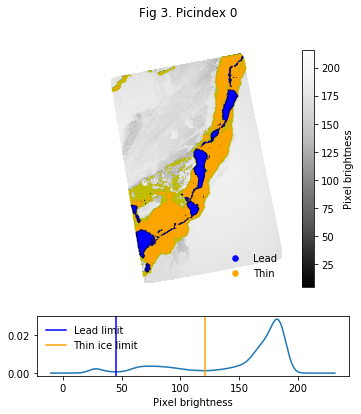

In [205]:
#Show the maximua/minima of the image
#Yellow points are ones that were flagged as grey, but were removed because 
# they were not at least 3m wide. Picindex 2 or 3 should have examples of shadows

fig = plt.figure(figsize=(5.6,6))
gs = GridSpec(2, 1, height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])
plt.imshow(masked_im, cmap='Greys_r')
a=plt.colorbar()
a.set_label("Pixel brightness")
ax1.axis('off')
ax2 = fig.add_subplot(gs[1])
ax2.plot(kde.support, kde.density)
#biggest contribution
biggest = peaks[kde.density[peaks].argmax()]
big_intensity = kde.support[biggest]
ax2.axvline(water_lim, c='b', label='Lead limit')
ax2.axvline(thin_lim, c='orange', label='Thin ice limit')
ax2.legend(frameon=False, loc='upper left')
ax2.set_xlabel("Pixel brightness")
ax1.scatter(lead_x, lead_y, s=.01, c='b', label="Lead", zorder=6)
ax1.scatter(thin_x, thin_y, s=.01, c='orange', label='Thin', zorder=6)
lgnd = ax1.legend(frameon=False)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax1.scatter(thinxs, thinys, s=.1, c='y',zorder=5)
ax1.scatter(leadxs, leadys, s=.1, c='navy', zorder=5)
fig.suptitle("Fig 3. Picindex {}".format(picindex))

Text(0.5, 1.0, 'Fig 4. First look at the elevation data, plotted on top of the image')

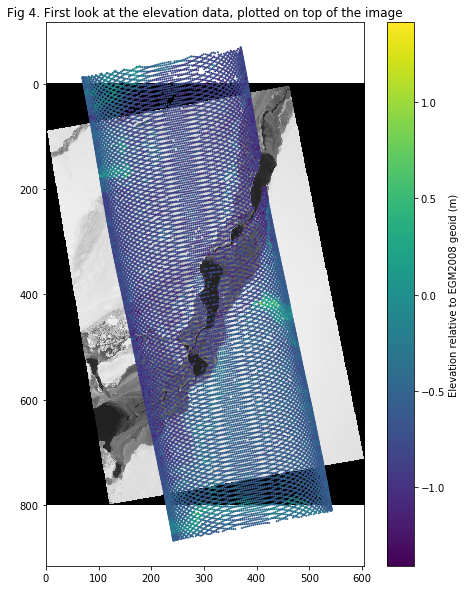

In [206]:
#Now for the hard part - mapping the lon/lat to x, y (pixels)
#To do this, we will assume that for this image, the earth is locally flat
# This is ok because the length scale of the image is around 300 x 400 m
# We will use the jpg's xml file, which has the lon/lat for the image corners (4 points)
# then we will find the linear transform (using a least-squares fitting) to transform 
# the (lon, lat) to (x, y).
pix_coords = np.array([[0, 0],  [im_bw.shape[1],0],  [im_bw.shape[1], im_bw.shape[0]], [0, im_bw.shape[0]]])
#Note the coordinates are upper left, right; lower right, left 
pix_latlons = np.array([lonsall2[picindex], latsall2[picindex]]).T
# Reference these relative to a corner, so that we don't deal with big numbers like 70, 100 etc
qi_shifted_lons = qi_lons - pix_latlons[0][0]
qi_shifted_lats = qi_lats - pix_latlons[0][1]#

# Also reference these relative to a corner
sorted_shifted_coords = np.array([pix_coords.T[0]-pix_coords[0][0], pix_coords.T[1]-pix_coords[0][1]]).T
sorted_shifted_lons = pix_latlons.T[0] - pix_latlons[0][0]
sorted_shifted_lats = pix_latlons.T[1] - pix_latlons[0][1]

#This is the linear transformation that maps (lons, lats) to (x, y)
LinTrans = np.linalg.lstsq(np.array([sorted_shifted_lons, sorted_shifted_lats]).T[[2,3]], sorted_shifted_coords[[2,3]], rcond=-1)[0]

#Apply the linear transform to the lon, lat data
xpix = LinTrans[0][0]*qi_shifted_lons + LinTrans[1][0]*qi_shifted_lats + pix_coords[0][0]
ypix = LinTrans[0][1]*qi_shifted_lons  + LinTrans[1][1]*qi_shifted_lats + pix_coords[0][1]
zpix = np.round(xpix)*10000+np.round(ypix)

plt.figure(figsize=(8,10))
plt.imshow(im_bw, cmap='Greys_r')
plt.scatter(xpix, ypix, s=1, c=qi_elevs)
c = plt.colorbar()
c.set_label("Elevation relative to EGM2008 geoid (m)")
plt.title("Fig 4. First look at the elevation data, plotted on top of the image")

In [207]:
#Now we just want to look at the elevation data that is a lead or thin ice

lead_filters = np.in1d(zpix, eroded_lead_ids)
thin_filters = np.in1d(zpix, eroded_thin_ids)
#we will sort them in anticpation of fitting Gaussians to the data
qi_fit_elevs = np.sort(qi_elevs[thin_filters])
thin_elevs = qi_elevs[thin_filters]
lead_elevs = qi_elevs[lead_filters]
qi_lead_elevs = np.sort(qi_elevs[lead_filters])

In [208]:
#Insist on at least 10 points for thin before proceeding
if np.sum(thin_filters)>=10 and np.sum(thin_filters)<6000:
	print("thin ice or lead found!")
	mean, std = stats.norm.fit(qi_fit_elevs)
	qi_fit_elevs = qi_fit_elevs[(qi_fit_elevs>np.median(qi_fit_elevs)-3*std)*(qi_fit_elevs<np.median(qi_fit_elevs)+3*std)]
	median = np.median(qi_fit_elevs)
	count=0
	badflag = False
    #This below algorithm keeps deleting the largest value
    #until a gaussian with sigma<0.11 is reached, with at least 15 data points left
    #otherwise it terminates and raises a 'badflag'. For more info, see 
    #Kurtz et al (2013), doi:10.5194/tc-7-1035-2013
	while std > 0.11 and count<150 and len(qi_fit_elevs)>15:
		count+=1
		qi_fit_elevs = qi_fit_elevs[:-1]
		mean, std = stats.norm.fit(qi_fit_elevs)
	if count==150 or std > 0.11:
		mean = median
		badflag = True
	yes = True
	value50 = np.median(qi_elevs[thin_filters])
	value_mean = np.mean(qi_elevs[thin_filters])
	rawstd = np.std(qi_fit_elevs)
	print("thin mean/median/gaussian: {:.3f}, {:.3f}, {:.3f}".format(value_mean, value50, mean))
else:
	value50, value_mean, rawstd, mean = 9,9,9,9
	print("No thin ice found!")
#you can save this data somewhere if you'd like. Don't forget to store the picindex so you can troubleshoot later!

thin ice or lead found!
thin mean/median/gaussian: -0.906, -0.905, -0.905


In [209]:
#same thing for the leads
if np.sum(lead_filters)>=10 and np.sum(lead_filters)<1000: #
	print("lead found!")
	lead_mean, lead_std = stats.norm.fit(qi_lead_elevs)
	qi_lead_elevs = qi_lead_elevs[(qi_lead_elevs>np.median(qi_lead_elevs)-3*lead_std)*(qi_lead_elevs<np.median(qi_lead_elevs)+3*lead_std)]
	median = np.median(qi_lead_elevs)
	count=0
	badflag = False
	while lead_std > 0.11 and count<150 and len(qi_lead_elevs)>15:
		count+=1
		qi_lead_elevs = qi_lead_elevs[:-1]
		lead_mean, lead_std = stats.norm.fit(qi_lead_elevs)
	if count==150 or lead_std > 0.11:
		lead_mean = median
		badflag = True
	# 	raise Exception("no good fit")
	yes = True
	lead50 = np.median(qi_elevs[lead_filters])
	lead_rawmean = np.mean(qi_elevs[lead_filters])
	leadstd = np.std(qi_lead_elevs)
	print("lead mean/median/gaussian: {:.3f},{:.3f},{:.3f}".format(lead_rawmean, lead50, lead_mean))
else:
	lead_rawmean, lead50, lead_mean, leadstd = 9,9,9,9
	print("No lead found!")
#you can save this data somewhere if you'd like. Don't forget to store the picindex so you can troubleshoot later!

lead found!
lead mean/median/gaussian: -0.846,-0.854,-0.900


Text(0.5, 1, 'Fig 5. Final lead-finding results')

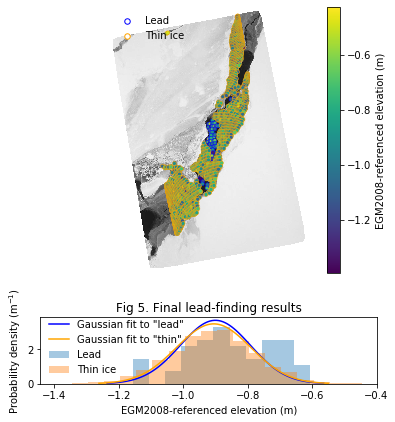

In [210]:
#Now we will show the final results, showing only the lead (blue) and thin (orange) pixels
fig = plt.figure(figsize=(5.6,6))
gs = GridSpec(2, 1, height_ratios=[4, 1])
ax1 = fig.add_subplot(gs[0])
plt.imshow(masked_im, cmap='Greys_r')
plt.axis('off')
# plt.scatter(xpix[~lead_filters], ypix[~lead_filters], c=qi_elevs[~lead_filters], alpha=0.5, s=5)
if np.sum(lead_filters)>=10:
	plt.scatter(xpix[lead_filters], ypix[lead_filters], c=(qi_elevs)[lead_filters], ec='b', lw=0.5, s=15)
if np.sum(thin_filters)>=10:
	plt.scatter(xpix[thin_filters], ypix[thin_filters], c=(qi_elevs)[thin_filters], ec='orange', lw=0.5,s=15)
t=plt.colorbar()
t.set_label("EGM2008-referenced elevation (m)")
plt.scatter(xpix.mean(), ypix.mean(), s=0, c='w', ec='b', label='Lead')
plt.scatter(xpix.mean(), ypix.mean(), s=0, c='w', ec='orange', label='Thin ice')
# plt.scatter(xpix.mean(), ypix.mean(), s=0, c='w', ec='g', label='Other')
lgnd = plt.legend(loc='upper left', frameon=False)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
ax2 = fig.add_subplot(gs[1])
#we will plot the distribution of the elevations, binned at 0.05 m.
if np.sum(lead_filters)>=10:
	sns.distplot(lead_elevs, label='Lead', kde=False, norm_hist=True, bins=np.arange(lead_elevs.min(), lead_elevs.max(),0.05))
	leadx = np.linspace(stats.norm.ppf(0.001, lead_mean, lead_std),stats.norm.ppf(0.999, lead_mean, lead_std), 100)
	plt.plot(leadx, stats.norm.pdf(leadx, lead_mean, lead_std), c='b', label='Gaussian fit to "lead"')
if np.sum(thin_filters)>=10:
	x = np.linspace(stats.norm.ppf(0.001, mean, std),stats.norm.ppf(0.999, mean, std), 100)
	sns.distplot(thin_elevs, label='Thin ice', kde=False, norm_hist=True, bins=np.arange(thin_elevs.min(), thin_elevs.max(),0.05))
	plt.plot(x, stats.norm.pdf(x, mean, std), c='orange', label='Gaussian fit to "thin"')
plt.xlabel("EGM2008-referenced elevation (m)")
plt.ylabel(r"Probability density (m$^{-1}$)")
plt.tight_layout()
plt.legend(frameon=False)
plt.title("Fig 5. Final lead-finding results")